In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [75]:
engagement = pd.read_csv("takehome_user_engagement.csv")
users = pd.read_csv("takehome_users.csv", encoding='latin-1')

In [76]:
print("User Engagement Data:")
print(engagement.head())
print("\nUsers Data:")
print(users.head())

User Engagement Data:
            time_stamp  user_id  visited
0  2014-04-22 03:53:30        1        1
1  2013-11-15 03:45:04        2        1
2  2013-11-29 03:45:04        2        1
3  2013-12-09 03:45:04        2        1
4  2013-12-25 03:45:04        2        1

Users Data:
   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09 

In [77]:
# Convert date and timestamp columns to datetime objects
users['creation_time'] = pd.to_datetime(users['creation_time'])
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])



In [78]:
#merge data sets on user, object id
merged_data = pd.merge(users, engagement, how='inner', left_on='object_id', right_on='user_id')


In [79]:
# Sort the data by user_id and time_stamp
merged_data.sort_values(by=['user_id', 'time_stamp'], inplace=True)

In [80]:
# Count total logins for each user
merged_data['total_logins'] = merged_data.groupby('user_id')['time_stamp'].transform('count')



In [81]:
# Calculate max logins in a seven-day rolling period
# Define a custom function to apply to each group
def rolling_count(group, freq):
    return group.rolling(window=freq, on='time_stamp')['time_stamp'].count()

# Apply the function to each group
freq = '7D'
merged_data['max_logins_7_days'] = merged_data.groupby('user_id').apply(lambda x: rolling_count(x, freq)).reset_index(level=0, drop=True)


In [82]:
# Merge adopted user data
merged_data = merged_data.drop_duplicates()



In [83]:
# 1. Identify Active Days
merged_data['active_day'] = merged_data['time_stamp'].dt.date



In [84]:
# 2. Calculate Active Days in a Week
# Define a function to apply the rolling operation for each group
def rolling_count(group):
    group = group.sort_values('time_stamp')
    group['time_stamp'] = pd.to_datetime(group['time_stamp'])
    # Apply rolling only to the required column and get the count
    rolling_counts = group.set_index('time_stamp')['user_id'].rolling('7D').count()
    group['7_day_active_count'] = rolling_counts.values  # Assign the rolling count values
    return group

# Apply the function to each group and concatenate the results
grouped = merged_data.groupby('user_id')
rolling_counts = pd.concat([rolling_count(group) for _, group in grouped])

# Now, merge the rolling count results back into the original DataFrame
merged_data = merged_data.drop(columns=['7_day_active_count'], errors='ignore')
merged_data = pd.merge(merged_data, rolling_counts[['user_id', 'time_stamp', '7_day_active_count']], on=['user_id', 'time_stamp'])


In [85]:
# 3. Define 'Adopted User'
merged_data['is_adopted_user'] = merged_data['7_day_active_count'] >= 3

# 4. Aggregate the Data
final_data = merged_data.groupby('user_id').agg(is_adopted_user=('is_adopted_user', 'max')).reset_index()

In [86]:
print(final_data['is_adopted_user'].value_counts())


is_adopted_user
False    7221
True     1602
Name: count, dtype: int64


In [87]:
merged_data.columns


Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'time_stamp', 'user_id', 'visited', 'total_logins', 'max_logins_7_days',
       'active_day', '7_day_active_count', 'is_adopted_user'],
      dtype='object')

In [88]:
numerical_columns = ['total_logins', 'max_logins_7_days', '7_day_active_count']
print(merged_data[numerical_columns].describe())


        total_logins  max_logins_7_days  7_day_active_count
count  207917.000000      207917.000000       207917.000000
mean      255.839777           4.381393            4.381393
std       157.722007           2.042666            2.042666
min         1.000000           1.000000            1.000000
25%       123.000000           3.000000            3.000000
50%       255.000000           4.000000            4.000000
75%       379.000000           6.000000            6.000000
max       606.000000           7.000000            7.000000


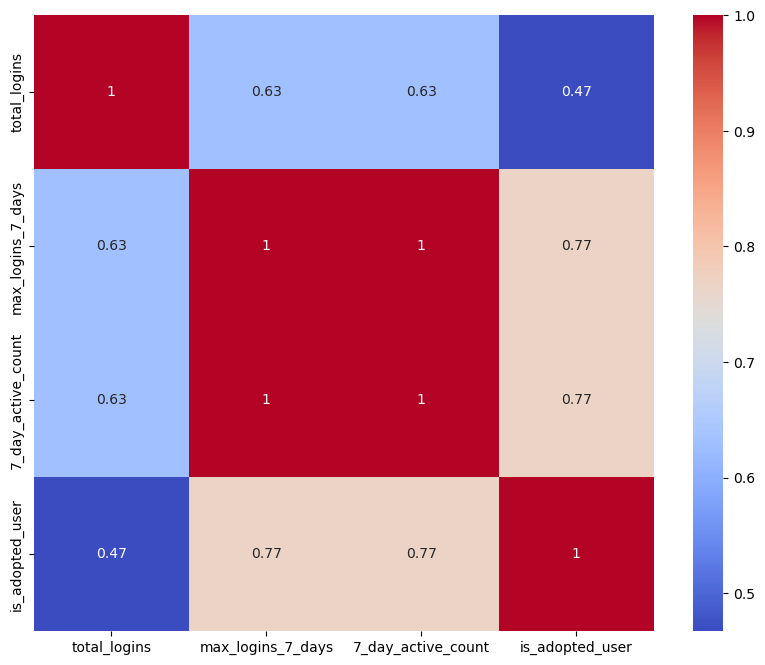

In [89]:
plt.figure(figsize=(10, 8))
sns.heatmap(merged_data[numerical_columns + ['is_adopted_user']].corr(), annot=True, cmap='coolwarm')
plt.show()


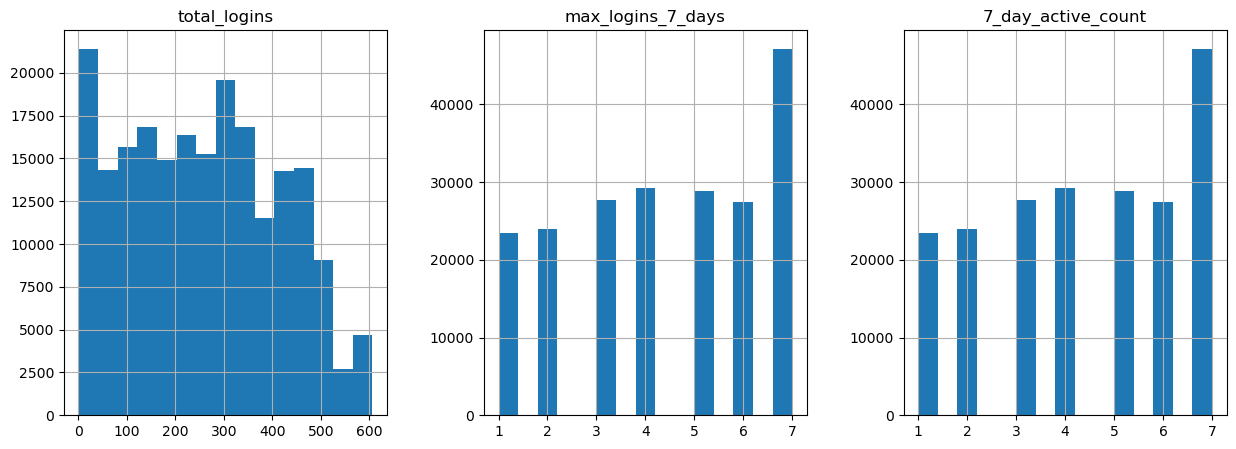

In [90]:
merged_data[numerical_columns].hist(bins=15, figsize=(15, 5), layout=(1, 3))
plt.show()



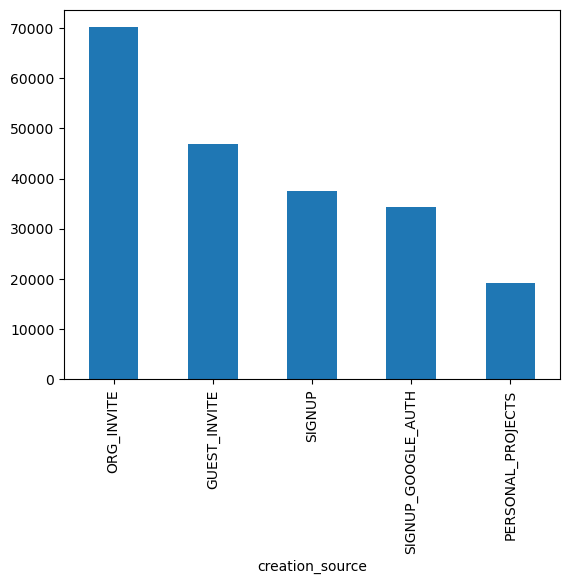

In [91]:
merged_data['creation_source'].value_counts().plot(kind='bar')
plt.show()


In [92]:
print(merged_data.groupby('is_adopted_user')[numerical_columns].mean())


                 total_logins  max_logins_7_days  7_day_active_count
is_adopted_user                                                     
False              120.257812           1.505412            1.505412
True               295.871096           5.230542            5.230542


In [93]:
print(merged_data.isnull().sum())


object_id                         0
creation_time                     0
name                              0
email                             0
creation_source                   0
last_session_creation_time        0
opted_in_to_mailing_list          0
enabled_for_marketing_drip        0
org_id                            0
invited_by_user_id            91030
time_stamp                        0
user_id                           0
visited                           0
total_logins                      0
max_logins_7_days                 0
active_day                        0
7_day_active_count                0
is_adopted_user                   0
dtype: int64


In [94]:
# Fill missing values in 'invited_by_user_id' with a placeholder (e.g., 0)
merged_data['invited_by_user_id'].fillna(0, inplace=True)

# Verify that there are no more missing values in this column
print(merged_data['invited_by_user_id'].isnull().sum())

0


In [114]:
md = merged_data

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score


In [115]:
encoder = LabelEncoder()
md['creation_source'] = encoder.fit_transform(merged_data['creation_source'])


In [116]:
md.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                        int64
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
time_stamp                    datetime64[ns]
user_id                                int64
visited                                int64
total_logins                           int64
max_logins_7_days                    float64
active_day                            object
7_day_active_count                   float64
is_adopted_user                         bool
dtype: object

In [117]:
y = md['is_adopted_user']


In [118]:
X = md.drop(['active_day','enabled_for_marketing_drip','max_logins_7_days','visited','user_id','is_adopted_user', 'name', 'email', 'object_id', 'creation_time', 'last_session_creation_time', 'time_stamp' ], axis=1)


In [119]:
X.dtypes

creation_source               int64
opted_in_to_mailing_list      int64
org_id                        int64
invited_by_user_id          float64
total_logins                  int64
7_day_active_count          float64
dtype: object

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [121]:
# Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [122]:
# Predictions and Evaluation
y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      9523
        True       1.00      1.00      1.00     32061

    accuracy                           1.00     41584
   macro avg       1.00      1.00      1.00     41584
weighted avg       1.00      1.00      1.00     41584



In [123]:
# Perform cross-validation
scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')

# Print the results
print(f"Accuracy scores for each fold: {scores}")
print(f"Average cross-validation score: {scores.mean()}")

Accuracy scores for each fold: [1. 1. 1. 1. 1.]
Average cross-validation score: 1.0


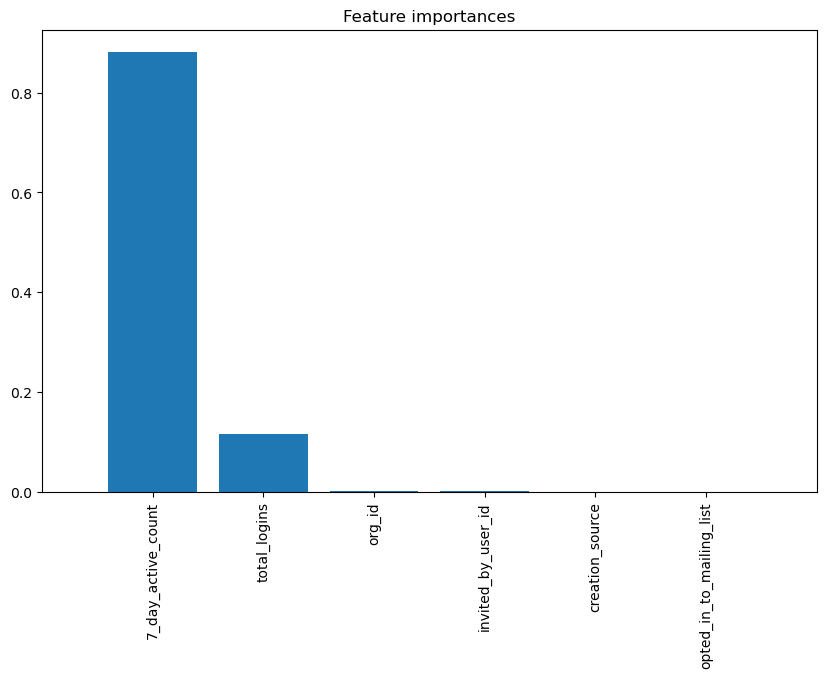

In [126]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()